# Clase 3. Modelos de Clasificación usando BQ

In [1]:
# change these to try this notebook out
BUCKET = 'modelo_en_gcp'
PROJECT = 'proyecto-covid-sds'
REGION = 'us-west1'
DATASET = 'modelo_en_gcp'

import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

## Configuraciones iniciales

In [87]:
execfile("functions/ML_train_functions_gcp.py")

In [3]:
try:
    import os
    os.chdir('ML_training_01/')
except:
    print("el folder actual es el señalado")

el folder actual es el señalado


El codigo "ML_train_functions_gcp" guarda funciones utiles para la ingeneria de datos entre ellos la case llamada "load_simple_file_class" 
Esta clase permite por medio de la funcion read_table() leer la tabla y obtener el esquema deseado

Iniciamos explorando los archivos que tenemos disponibles para cargar

In [9]:
%%bash
ls data/*.csv

data/FONDO_EPM.csv
data/Fondo_PP.csv
data/fraude.csv


Revisamos la cantidad de registros que tenemos para las bases disponibles por medio del siguiente codigo de bash o usando la terminal

In [10]:
%%bash
wc -l data/*.csv

   399298 data/FONDO_EPM.csv
  1048576 data/Fondo_PP.csv
    26976 data/fraude.csv
  1474850 total


In [11]:
%%bash
head -1 data/FONDO_EPM.csv

﻿OPERADOR INICIAL;CONVOCATORIA;ID USUARIO (TI);ID SOLICITUD (COMFAMA/FIDUCIARIA);ID Y CONVOTORIA;ID Y 2021-2;TIPO DE DOCUMENTO;MODALIDAD;NIVEL FORMACION;SECTOR;IES;PROGRAMA;GENERO;FECHA DE NACIMIENTO;DEPARTAMENTO DE RESIDENCIA;MUNICIPIO DE RESIDENCIA;TIEMPO DE RESIDENCIA EN EL MUNICIPIO;COMUNA DE RESIDENCIA;ESTRATO;SISBÉN;CORREO ALTERNO;DISCAPACIDAD;TIPO DE DISCAPACIDAD;LGTBI;DESMOVILIZADO;DESPLAZADO;REINSERTADO;VICTIMA DEL CONFLICTO;HECHO VICTIMIZANTE;AFROCOLOMBIANO;TIPO AFROCOLOMBIANO;INDIGENA;ETNIA;TECNOLOGO;TECNICO;CICLO PROPEDEUTICO U HOMOLOGACION;RECIBE OTRO APOYO;MODALIDAD DE OTRO APOYO;TIPO DE OTRO APOYO;TIPO DOCUMENTO DEUDOR;PARENTESCO DEUDOR;SEMESTRES A FINANCIAR;SEMESTRE DE INGRESO;DURACION DEL PROGRAMA;GIROS REALIZADOS;GIROS PENDIENTES;MONTO MATRÍCULA;MONTO SOSTENIMIENTO;MONTO TOTAL;MONTO DEL 10%;PERÍODO RENOVADO;ESTADO SEMESTRAL;DESCRIPCIÓN DE ESTADO;OBSERVACIÓN LLAMADAS;ESTADO ODES 2022-1 ;ESTADO 2022-1;ESTADO POR PERIODO;MOTIVO SUSPENSION;MOTIVO ESTADO 2022-1;ETAPA DEL P

Observamos el encabezado por medio del codigo

In [37]:
execfile("functions/ML_train_functions_gcp.py")

In [21]:
encabezado = encabezado('FONDO_EPM', delimitador = ';')
columnas = encabezado.split(";")
squema_bq = schema_bq(columnas)

In [22]:
squema_bq

[SchemaField('OPERADOR_INICIAL', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('CONVOCATORIA', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('ID_USUARIO_TI_', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('ID_SOLICITUD_COMFAMA_FIDUCIARIA_', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('ID_Y_CONVOTORIA', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('ID_Y_20212', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('TIPO_DE_DOCUMENTO', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('MODALIDAD', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('NIVEL_FORMACION', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('SECTOR', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('IES', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('PROGRAMA', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('GENERO', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('FECHA_DE_NACIMIENTO', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('DEPARTAMENTO_DE_RESI

## Leer datos optimos para usar en BigQuery
Este paso implica que todas las columnas pueden ser cargadas en bigquery facilmente en strings y que posteriormente se pueden convertir al formato deseado

Los Archivos en sistemas de ingrados de informacion, generalmente no permiten titulos de columnas con caracteres especiales, tildes o espacios. La siguiente clase permite leer de forma normalizada los titulos. Inicialmente leemos una clase hecha para esto, en seguida leemos el archivo, al usar la funcion "load_simple_file_class" obtenemos la tabla, el schema_ apropiado para cargar en Bigquery, y el nombre de las columnas

In [38]:
clase = load_simple_file_class(path = "data/FONDO_EPM.csv", delimit = ";" ).read_table()
data = clase[0]
squema= clase[1]


esquema creado correctamente


## Cargar datos en Bigquery
Veremos como se cargan datos a bigquery, crearemos un dataset donde alojaremos toda la informacion del modelo, ademas crearemos las condiciones deseadas de los datos de entrenamiento y de test

##### Create BigQuery dataset

Creremos un dataset llamado DATASET = `'modelo_en_gcp'`, dentro de este dataset se alojara los datos y los modelos de  BQML.

In [49]:
# Activamos la conexion con bigquery 
bq_client = bigquery.Client(project=PROJECT)
# Create BigQuery dataset
# dataset = bq_client.create_dataset(DATASET)

Ahora usamos la funcion `load_simple_file_in_bq`para cargar la tabla que hemos leido y tenemos guardada

In [41]:
 
load_simple_file_in_bq(dataset = DATASET,
                       data = data, squema =  squema,
                       table_in_bq = 'FONDO_EPM')


La tabla cargo correctamente en proyecto-covid-sds.modelo_en_gcp.FONDO_EPM


##  Lectura de datos en Python y Feature Engineering 

In [52]:
table_in_bq = 'FONDO_EPM'
query = """
SELECT *
FROM `{}.{}.{}`
LIMIT 5
""".format(PROJECT, DATASET,table_in_bq )
dataset = bq_client.query(query).to_dataframe()
dataset

,OPERADOR_INICIAL_1,CONVOCATORIA_2,ID_USUARIO_TI__3,ID_SOLICITUD_COMFAMA_4,ID_Y_CONVOTORIA_5,ID_Y_20212_6,TIPO_DE_DOCUMENTO_7,MODALIDAD_8,NIVEL_FORMACION_9,SECTOR_10,...,GIROS_REALIZADOS_COR_61,GIROS_PENDIENTES_COR_62,GIROS_REALIZADOS_COR_63,GIROS_PENDIENTES_COR_64,RENOVARON_20221_65,HABILITADO_PARA_RENO_66,PERIODO_DE_GRACIA_67,TOTAL_CREDITOS_DE_LA_68,PUNTAJE_69,PUNTO_DE_CORTE_70
0,COMFAMA (recibido),2008-2,96875,4420,8026327 - 2008-2,80263272008-2,Cédula de ciudadanía,Matricula y Sostenimiento,Tecnologia,pendiente,...,1,4,1,4,nan,NO,No aplica,pendiente,50,pendiente
1,COMFAMA (recibido),2008-2,74074,7557,35898477 - 2008-2,358984772008-2,Cédula de ciudadanía,Matricula y Sostenimiento,Profesional,pendiente,...,1,4,1,4,nan,NO,No aplica,pendiente,53,pendiente
2,COMFAMA (recibido),2008-2,78114,11135,43606371 - 2008-2,436063712008-2,Cédula de ciudadanía,Matricula,Profesional,pendiente,...,1,6,1,6,nan,NO,No aplica,pendiente,51,pendiente
3,COMFAMA (recibido),2008-2,103102,10512,43618461 - 2008-2,436184612008-2,Cédula de ciudadanía,Matricula y Sostenimiento,Profesional,pendiente,...,1,1,1,1,nan,NO,No aplica,pendiente,48,pendiente
4,COMFAMA (recibido),2008-2,71843,1942,43904308 - 2008-2,439043082008-2,Cédula de ciudadanía,Sostenimiento,Tecnologia,pendiente,...,1,0,1,0,nan,NO,No aplica,pendiente,60,pendiente


In [2]:
!ls

'Capacitación  Introducción ML.ipynb'


### Transformaciones simples

#### Crear funciones en BQ que faciliten la limpieza

Esta fecha tiene como proposito facilitar la limpieza de fehcas, el caso especifico se refiere a fechas de nacimientos que vienen en al menos 5 formatos, 
>>
'%Y-%m-%d'
>>
'%d/%m/%Y'
>>
'%d/%m/%y'
>>
'%d/%mm/%Y'

En esta funcion detectamos el año y lo tomamos en formato string
es importante establecer `function_name`, este sera el nombre con el que se guardara la funcion dentro del dataset del poryecto deseado

In [53]:
function_name = 'anios_de_fechas'

In [58]:
query = """
CREATE OR REPLACE FUNCTION `{}.{}.udfs_{}`(FECHA STRING) AS (
CASE 
  WHEN CHAR_LENGTH( SPLIT(LEFT(FECHA, 5) , "-")[SAFE_OFFSET(0)] ) = 4
      AND SAFE_CAST( SPLIT(LEFT(FECHA, 5) , "-")[SAFE_OFFSET(0)]  AS NUMERIC) IS NOT NULL 
      THEN SPLIT(LEFT(FECHA, 5) , "-")[SAFE_OFFSET(0)]  
  WHEN right(FECHA,3) LIKE '%/%' 
      AND LEFT(right(FECHA,3) ,2) ='/9' 
      THEN  '19'||right(FECHA,2) 
  WHEN right(FECHA,3) LIKE '%/%' 
      AND LEFT(right(FECHA,3) ,2) ='/8' 
      THEN  '198'||right(FECHA,2) 
  WHEN right(FECHA,3) LIKE '%/%' 
      AND LEFT(right(FECHA,3) ,2) ='/0' 
      THEN  '20'||right(FECHA,2)       
  WHEN SAFE_CAST(right(FECHA,4) AS NUMERIC) IS NOT NULL  
      AND SAFE_CAST(right(FECHA,4) AS NUMERIC) BETWEEN 1910 AND 2050 
      THEN right(FECHA,4) 
      
ELSE NULL END
       
);
""".format(PROJECT, DATASET, function_name)


In [59]:
## CORREMOS EL QUERY PARA QUE LA FUNCION CREADA QUEDE GUARDADA EN EL DATASET CREADO
bq_client.query(query).to_dataframe()

""


In [70]:
function_name = 'drop_tildes'
query = """
CREATE OR REPLACE FUNCTION `{}.{}.udfs_{}`(X STRING) AS (
REPLACE(
REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(UPPER(X),'Á', 'A'),'É', 'E'),'Í', 'I'),'Ó', 'O'),'Ú', 'U')
,'Ü', 'U' )      
);
""".format(PROJECT, DATASET, function_name)
bq_client.query(query).to_dataframe()

""


In [ ]:
# Probamos  la funcion 

In [67]:
query = """
SELECT
DISTINCT
`{}.{}.udfs_{}`(FECHA_DE_NACIMIENTO_14) ANO_NACIMIENTO, FECHA_DE_NACIMIENTO_14 FECHA_DE_NACIMIENTO
FROM `{}.{}.{}` 
where 
    LEFT(right(FECHA_DE_NACIMIENTO_14,3) ,2) ='/9' 
    --LEFT(FECHA_DE_NACIMIENTO_14,4)  ='1993'
LIMIT 5

""".format(PROJECT, DATASET, function_name,PROJECT, DATASET, table_in_bq)
bq_client.query(query).to_dataframe()

,ANO_NACIMIENTO,FECHA_DE_NACIMIENTO
0,1999,05/04/99
1,1995,22/02/95
2,1997,29/12/97
3,1999,13/11/99
4,1997,17/06/97


In [72]:
TABLA_LIMPIA = 'fondo_epm_limpia'
QUERY = """
CREATE OR REPLACE VIEW `{}.{}.{}`
OPTIONS () AS
SELECT * FROM (
SELECT
CASE WHEN LOWER(NIVEL_FORMACION_9) LIKE '%tecno%' then 'TECNOLOGICA'
WHEN LOWER(NIVEL_FORMACION_9) LIKE 'profesional' then 'PROFESIONAL'
WHEN LOWER(NIVEL_FORMACION_9) LIKE '%tecni%' then 'TECNICO'
WHEN LOWER(NIVEL_FORMACION_9) LIKE '%universi%' then 'PROFESIONAL'
ELSE NULL END AS NIVEL_FORMACION,
ROW_NUMBER() OVER (PARTITION BY ID_Y_20212_6 
ORDER BY 
    SAFE_CAST(LEFT( RIGHT(REPLACE(ESTADO_20221_56, ' ',''), 6),4) 
          AS NUMERIC)
      DESC  NULLS LAST) RN,
 
SAFE_CAST(LEFT( RIGHT(REPLACE(ESTADO_20221_56, ' ',''), 6),4) AS NUMERIC) ANO_ESTADO --,*
,
CASE WHEN LOWER(ESTADO_20221_56) LIKE '%de_ertor%'
    THEN 1 ELSE 0 END DESERTOR, 
(SAFE_CAST( LEFT( RIGHT(REPLACE(ESTADO_20221_56, ' ',''), 6),4)  AS NUMERIC) -    
SAFE_CAST(`proyecto-covid-sds.modelo_en_gcp.udfs_anios_de_fechas`(FECHA_DE_NACIMIENTO_14)  AS NUMERIC))
AS ANIOS_NACIMIENTO_ESTADO_2022,

SAFE_CAST(RIGHT(ESTRATO_19, 1) AS NUMERIC) ESTRATO,

CASE WHEN  UPPER(TIPO_DE_DISCAPACIDAD_23)	 LIKE '%COGNI%' THEN 1 ELSE 0 END COGNITIVA, 
CASE WHEN  UPPER(TIPO_DE_DISCAPACIDAD_23)	 LIKE '%AUDI%' THEN 1 ELSE 0 END AUDITIVA, 
CASE WHEN  UPPER(TIPO_DE_DISCAPACIDAD_23)	 LIKE '%F_SICA%' THEN 1
    WHEN  UPPER(TIPO_DE_DISCAPACIDAD_23)	 LIKE '%MOTRIZ%'  THEN 1 ELSE 0 END FISICA, 
CASE WHEN  UPPER(TIPO_DE_DISCAPACIDAD_23)	 LIKE '%VISUAL%' THEN 1 ELSE 0 END VISUAL,
CASE WHEN  UPPER(TIPO_DE_DISCAPACIDAD_23)	 LIKE '%M_LTIPLE%' THEN 1 ELSE 0 END MULTIPLE,
CASE WHEN UPPER(LGTBI_24) LIKE '%SI%' THEN 1 ELSE 0 END AS LGTBI,
CASE WHEN UPPER(DESMOVILIZADO_25) LIKE '%SI%' THEN 1 ELSE 0 END AS DESMOVILIZADO,
CASE WHEN UPPER(DESPLAZADO_26) LIKE '%SI%' THEN 1 ELSE 0 END AS DESPLAZADO,
CASE WHEN UPPER(REINSERTADO_27) LIKE '%SI%' THEN 1 ELSE 0 END AS REINSERTADO,
CASE WHEN UPPER(VICTIMA_DEL_CONFLICT_28) LIKE '%SI%' THEN 1 ELSE 0 END AS VICTIMA_DEL_CONFLICTO,
CASE WHEN UPPER(HECHO_VICTIMIZANTE_29) LIKE '%SI%' THEN 1 ELSE 0 END AS HECHO_VICTIMIZANTE,
CASE WHEN UPPER(AFROCOLOMBIANO_30) LIKE '%SI%' THEN 1 ELSE 0 END AS AFROCOLOMBIANO,
CASE WHEN UPPER(TIPO_AFROCOLOMBIANO_31) LIKE '%SI%' THEN 1 ELSE 0 END AS TIPO_AFROCOLOMBIANO,
CASE WHEN UPPER(INDIGENA_32) LIKE '%SI%' THEN 1 ELSE 0 END AS INDIGENA,
CASE WHEN UPPER(TECNOLOGO_34) LIKE '%SI%' THEN 1 ELSE 0 END AS TECNOLOGO,
CASE WHEN UPPER(TECNICO_35) LIKE '%SI%' THEN 1 ELSE 0 END AS TECNICO,
 
(CASE 
WHEN UPPER(PARENTESCO_DEUDOR_41) LIKE '%HERM%' THEN 'HERMANO'
WHEN UPPER(PARENTESCO_DEUDOR_41) LIKE '%ADRE%' THEN 'PADRES'
WHEN UPPER(PARENTESCO_DEUDOR_41) LIKE '%ABUE%' THEN 'ABUELOS'
WHEN UPPER(PARENTESCO_DEUDOR_41) LIKE '%T_O' OR UPPER(PARENTESCO_DEUDOR_41) LIKE '%T_A' THEN 'TIOS'
ELSE 'OTRO' END ) AS PARENTESCO_DEUDOR,
 SAFE_CAST(SEMESTRES_A_FINANCIA_42 AS NUMERIC) AS SEMESTRES_A_FINANCIA, 
 SAFE_CAST(SEMESTRE_DE_INGRESO_43 AS NUMERIC) AS SEMESTRE_DE_INGRESO, 
  REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
  REPLACE(REPLACE(RTRIM(LTRIM(
  TRIM(REPLACE(UPPER(IES_11), 'UPB',''))
  , ' '), ' '), '-',''), '  ',' '), 'FUNLAM', '')
  , 'UNIVERSITARIACEIPA', 'UNIVERSITARIA CEIPA'), ' IUMAFIS', '')
  , 'UNIVERSIDAD PONTIFICIA BOLIVARIANA ','UNIVERSIDAD PONTIFICIA BOLIVARIANA')
, 'GRANCOLOMBIANO', 'GRAN COLOMBIANO'), ' ITM', ''), 'LATINOAMERICANAUNAULA', 'LATINOAMERICANA UNAULA')
, 'INSTITUCION UNIVERSITARIA COLEGIO MAYOR DE ANTIOQUIA', 'COLEGIO MAYOR DE ANTIOQUIA') AS IES,

CASE
WHEN UPPER(GENERO_13)  LIKE '%FEM%' THEN 'F'
WHEN UPPER(GENERO_13)  LIKE '%MU%' THEN 'F'
WHEN UPPER(GENERO_13)  LIKE '%HOM%' THEN 'M'
WHEN UPPER(GENERO_13)  LIKE '%MAS%' THEN 'M'
ELSE 'I' END
GENERO,
`proyecto-covid-sds.modelo_en_gcp.udfs_drop_tildes`(UPPER(MUNICIPIO_DE_RESIDEN_16)) MUNICIPIO_DE_RESIDEN, 
 UPPER(TIEMPO_DE_RESIDENCIA_17) AS TIEMPO_DE_RESIDENCIA, 
  	--SAFE_CAST(SEMESTRE_DE_INGRESO_43 AS NUMERIC) AS SEMESTRE_DE_INGRESO,
    SAFE_CAST(GIROS_PENDIENTES_46 AS NUMERIC) AS GIROS_PENDIENTES,

CASE WHEN MONTO_MATRICULA_47 LIKE '%$ -%' THEN 0 ELSE SAFE_CAST( 
 REPLACE(REPLACE(REPLACE(MONTO_MATRICULA_47 , '$ ',''), '.',''), ' ','')
AS NUMERIC) END AS MONTO_MATRICULA,
CASE WHEN MONTO_SOSTENIMIENTO_48 LIKE '%$ -%' THEN 0 ELSE SAFE_CAST( 
 REPLACE(REPLACE(REPLACE(MONTO_SOSTENIMIENTO_48 , '$ ',''), '.',''), ' ','')
AS NUMERIC) END AS MONTO_SOSTENIMIENTO, 
 SAFE_CAST(PUNTAJE_69 AS NUMERIC) PUNTAJE
FROM `{}.{}.{}`
)
WHERE RN = 1
 
and NIVEL_FORMACION IS NOT NULL 
and ANO_ESTADO IS NOT NULL 
and DESERTOR IS NOT NULL 
and ANIOS_NACIMIENTO_ESTADO_2022 IS NOT NULL 
and ESTRATO IS NOT NULL 
and COGNITIVA IS NOT NULL 
and AUDITIVA IS NOT NULL 
and FISICA IS NOT NULL 
and VISUAL IS NOT NULL 
and MULTIPLE IS NOT NULL 
and LGTBI IS NOT NULL 
and DESMOVILIZADO IS NOT NULL 
and DESPLAZADO IS NOT NULL 

and REINSERTADO IS NOT NULL 
and VICTIMA_DEL_CONFLICTO IS NOT NULL 
and HECHO_VICTIMIZANTE IS NOT NULL 
and AFROCOLOMBIANO IS NOT NULL 

and TIPO_AFROCOLOMBIANO IS NOT NULL 
and INDIGENA IS NOT NULL 
and TECNICO IS NOT NULL 
and TECNOLOGO IS NOT NULL 
and PARENTESCO_DEUDOR IS NOT NULL 

and SEMESTRES_A_FINANCIA IS NOT NULL 
and SEMESTRE_DE_INGRESO IS NOT NULL 
and IES IS NOT NULL 
and GENERO IS NOT NULL 
and MUNICIPIO_DE_RESIDEN IS NOT NULL 
and TIEMPO_DE_RESIDENCIA IS NOT NULL 
and GIROS_PENDIENTES IS NOT NULL 
and MONTO_MATRICULA IS NOT NULL 
and MONTO_SOSTENIMIENTO IS NOT NULL 
""".format(PROJECT, DATASET, TABLA_LIMPIA,PROJECT, DATASET, table_in_bq)
bq_client.query(QUERY).to_dataframe()

""


# Getting started: Training and Prediction with BigQuery ML


<img src="https://wwwstatic-c.lookercdn.com/partner_network/pages/google/bigquery_v0002.png" width="120" align="middle"/>

### Costos
En este instructivo, se usan componentes facturables de Cloud Platform, que incluyen:

- Google BigQuery
- BigQueryML

Más información sobre [Google BigQuery
precios](https://cloud.google.com/bigquery/docs/controlling-costs) y [Cloud Storage
precios](https://cloud.google.com/storage/pricing) y use el [Pricing
Calculadora](https://cloud.google.com/bigquery/docs/estimate-costs)
para generar una estimación de costos basada en su uso proyectado.

#### Descargamos los datos de Bigquery
Descargamos los datos que guardamos limpios y listos para procesar con la intencion de correrlos en el `AutoML classification` 

In [88]:
execfile("functions/ML_train_functions_gcp.py")

In [136]:
TABLA_LIMPIA = 'fondo_epm_limpia'
query = """
SELECT *
FROM `{}.{}.{}`
 
""".format(PROJECT, DATASET,TABLA_LIMPIA )
data = bq_client.query(query).to_dataframe()
data.head(5)

,IDENTIFICADOR_UNICO,NIVEL_FORMACION,RN,ANO_ESTADO,DESERTOR,ANIOS_NACIMIENTO_ESTADO_2022,ESTRATO,COGNITIVA,AUDITIVA,FISICA,...,SEMESTRES_A_FINANCIA,SEMESTRE_DE_INGRESO,IES,GENERO,MUNICIPIO_DE_RESIDEN,TIEMPO_DE_RESIDENCIA,GIROS_PENDIENTES,MONTO_MATRICULA,MONTO_SOSTENIMIENTO,PUNTAJE
0,10000838632020-1,PROFESIONAL,1,2022.000000000,0,23.000000000,2.000000000,0,0,0,...,10.000000000,1.000000000,UNIVERSIDAD CATOLICA LUIS AMIGO,F,MEDELLIN,60 MESES EN ADELANTE,4.000000000,2633409.000000000,2194507.000000000,90.000000000
1,10000843992021-1,PROFESIONAL,1,2021.000000000,0,25.000000000,1.000000000,0,0,0,...,9.000000000,1.000000000,UNIVERSIDAD DE MEDELLIN,M,MEDELLIN,60 MESES EN ADELANTE,0E-9,0E-9,0E-9,100.000000000
2,10000883192020-2,PROFESIONAL,1,2022.000000000,0,21.000000000,1.000000000,1,0,0,...,10.000000000,1.000000000,UNIVERSIDAD AUTONOMA LATINOAMERICANA UNAULA,F,MEDELLIN,60 MESES EN ADELANTE,5.000000000,2101546.000000000,2194507.000000000,105.000000000
3,10000888452018-1,PROFESIONAL,1,2022.000000000,0,21.000000000,2.000000000,0,0,0,...,10.000000000,1.000000000,UNIVERSIDAD CATOLICA LUIS AMIGO,F,MEDELLIN,60 MESES EN ADELANTE,9.000000000,2103276.000000000,1953105.000000000,110.000000000
4,10000888982019-1,PROFESIONAL,1,2022.000000000,0,21.000000000,2.000000000,0,0,0,...,9.000000000,1.000000000,UNIVERSIDAD DE MEDELLIN,F,MEDELLIN,0,6.000000000,2484348.000000000,2070290.000000000,103.000000000


In [107]:
data.columns

Index(['NIVEL_FORMACION', 'RN', 'ANO_ESTADO', 'DESERTOR',
       'ANIOS_NACIMIENTO_ESTADO_2022', 'ESTRATO', 'COGNITIVA', 'AUDITIVA',
       'FISICA', 'VISUAL', 'MULTIPLE', 'LGTBI', 'DESMOVILIZADO', 'DESPLAZADO',
       'REINSERTADO', 'VICTIMA_DEL_CONFLICTO', 'HECHO_VICTIMIZANTE',
       'AFROCOLOMBIANO', 'TIPO_AFROCOLOMBIANO', 'INDIGENA', 'TECNOLOGO',
       'TECNICO', 'PARENTESCO_DEUDOR', 'SEMESTRES_A_FINANCIA',
       'SEMESTRE_DE_INGRESO', 'IES', 'GENERO', 'MUNICIPIO_DE_RESIDEN',
       'TIEMPO_DE_RESIDENCIA', 'GIROS_PENDIENTES', 'MONTO_MATRICULA',
       'MONTO_SOSTENIMIENTO', 'PUNTAJE'],
      dtype='object')

[Text(0, 0, 'No DESERTOR'), Text(1, 0, 'DESERTOR')]

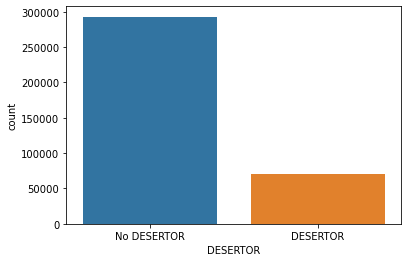

In [119]:
import seaborn as sns
# visualize the target variable
g = sns.countplot(data['DESERTOR'])
g.set_xticklabels(['No DESERTOR','DESERTOR'])

In [ ]:
DESERTOR

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Transformaciones

In [121]:
execfile("functions/ML_train_functions_gcp.py")

In [122]:
VARIABLES_INDEPENDIENTES= ['NIVEL_FORMACION', 'RN', 'ANO_ESTADO', 'ANIOS_NACIMIENTO_ESTADO_2022',
                           'ESTRATO', 'COGNITIVA', 'AUDITIVA', 'FISICA',
                           'VISUAL', 'MULTIPLE', 'LGTBI', 'DESMOVILIZADO', 'DESPLAZADO',
                           'REINSERTADO', 'VICTIMA_DEL_CONFLICTO', 'HECHO_VICTIMIZANTE',
                           'AFROCOLOMBIANO', 'TIPO_AFROCOLOMBIANO', 'INDIGENA', 'TECNOLOGO',
                           'TECNICO', 'PARENTESCO_DEUDOR', 'SEMESTRES_A_FINANCIA',
                           'SEMESTRE_DE_INGRESO', 'IES', 'GENERO', 'MUNICIPIO_DE_RESIDEN',
                           'TIEMPO_DE_RESIDENCIA', 'GIROS_PENDIENTES', 'MONTO_MATRICULA',
                           'MONTO_SOSTENIMIENTO', 'PUNTAJE' ] 
VARIABLE_DEPENDEINTE = 'DESERTOR'
VARIABLES_INDEP_NUMERICAS = [ 'RN', 'ANO_ESTADO', 'ANIOS_NACIMIENTO_ESTADO_2022', 
                             'COGNITIVA', 'AUDITIVA', 'FISICA',
                           'VISUAL', 'MULTIPLE', 'LGTBI', 'DESMOVILIZADO', 'DESPLAZADO',
                           'REINSERTADO', 'VICTIMA_DEL_CONFLICTO', 'HECHO_VICTIMIZANTE',
                           'AFROCOLOMBIANO', 'TIPO_AFROCOLOMBIANO', 'INDIGENA', 'TECNOLOGO',
                           'TECNICO',  'SEMESTRES_A_FINANCIA',
                           'SEMESTRE_DE_INGRESO' ,  'GIROS_PENDIENTES', 'MONTO_MATRICULA',
                           'MONTO_SOSTENIMIENTO', 'PUNTAJE'
                            ]
VARIABLES_INDEP_CATEGORICAS = [ 'NIVEL_FORMACION',   'ESTRATO',   'IES', 'MUNICIPIO_DE_RESIDEN', 
                               'PARENTESCO_DEUDOR', 'TIEMPO_DE_RESIDENCIA',  'GENERO' ]

X_train, X_test, y_train, y_test =  feature_eng(tabla=data, 
                                                                    X=VARIABLES_INDEPENDIENTES,
                                                                     Y=VARIABLE_DEPENDEINTE,
                                                                     X_num=VARIABLES_INDEP_NUMERICAS ,
                                                                     X_Cat=VARIABLES_INDEP_CATEGORICAS )
 

In [123]:
X_train.head(2)

,RN,ANO_ESTADO,ANIOS_NACIMIENTO_ESTADO_2022,COGNITIVA,AUDITIVA,FISICA,VISUAL,MULTIPLE,LGTBI,DESMOVILIZADO,...,PARENTESCO_DEUDOR_TIOS,TIEMPO_DE_RESIDENCIA_0,TIEMPO_DE_RESIDENCIA_1 A 23 MESES,TIEMPO_DE_RESIDENCIA_24 A 35 MESES,TIEMPO_DE_RESIDENCIA_36 A 59 MESES,TIEMPO_DE_RESIDENCIA_60 MESES EN ADELANTE,TIEMPO_DE_RESIDENCIA_NO APLICA,GENERO_F,GENERO_I,GENERO_M
336701,1,2013.000000000,24.000000000,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
133704,1,2013.000000000,23.000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## AUTOML
 Escribe tu codigo

In [124]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *

In [126]:
%%time
automl_class = funcion_automl(X_train , y_train ,  y_test , X_test )
resultado = automl_class.run_automl_models()
resultado  

Modelo XGBClassifier no pudo ser calculado
CPU times: user 48.3 s, sys: 5.06 s, total: 53.3 s
Wall time: 40.7 s


,Accuracy,Precision,Recall,F1,ROC-AUC
Modelo,,,,,
Regresion Logistica,0.807088,0.000000,0.000000,0.000000,0.500000
Naive Bayes,0.807110,1.000000,0.000114,0.000228,0.500057
Árbol de Decisión,0.955145,0.873295,0.897737,0.885347,0.933302
Random Forest,0.979689,0.982242,0.911190,0.945382,0.953626


#### Over-sampling

In [128]:
class_count_0, class_count_1 = data['DESERTOR'].value_counts()
# Separate class
class_0 = data[data['DESERTOR'] == 0]
class_1 = data[data['DESERTOR'] == 1]
 # print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (292937, 33)
class 1: (70812, 33)


[Text(0, 0, 'No fraude'), Text(1, 0, 'fraude')]

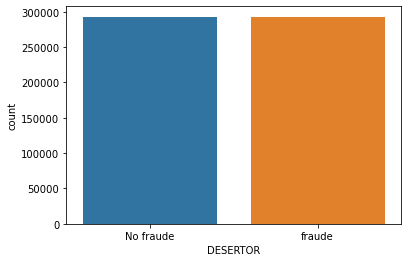

In [129]:
class_1_over = class_1.sample(class_count_0, replace=True)
data_over = pd.concat([class_1_over, class_0], axis=0)
sns.countplot(data_over['DESERTOR']).set_xticklabels(['No fraude','fraude'])

In [130]:
%%time
X_train, X_test, y_train, y_test = feature_eng(tabla=data_over, 
                                               X=VARIABLES_INDEPENDIENTES,
                                               Y=VARIABLE_DEPENDEINTE,
                                               X_num=VARIABLES_INDEP_NUMERICAS ,
                                               X_Cat=VARIABLES_INDEP_CATEGORICAS )
 
automl_class = funcion_automl(X_train , y_train ,  y_test , X_test )
resultado = automl_class.run_automl_models()
resultado  

Modelo XGBClassifier no pudo ser calculado
CPU times: user 1min 15s, sys: 7.48 s, total: 1min 23s
Wall time: 1min 6s


,Accuracy,Precision,Recall,F1,ROC-AUC
Modelo,,,,,
Regresion Logistica,0.631198,0.621321,0.667679,0.643667,0.631280
Naive Bayes,0.501164,0.557377,0.000465,0.000930,0.500049
Árbol de Decisión,0.978753,0.963114,0.995539,0.979058,0.978791
Random Forest,0.995678,0.993299,0.998070,0.995679,0.995684


#### Under-sampling

[Text(0, 0, 'No fraude'), Text(1, 0, 'fraude')]

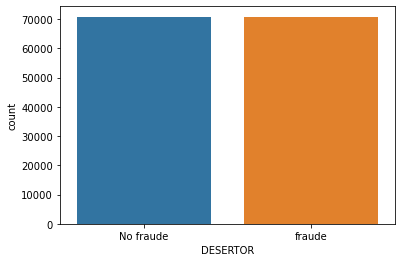

In [131]:
class_0_under = class_0.sample(class_count_1)
data_under = pd.concat([class_0_under, class_1], axis=0)
sns.countplot(data_under['DESERTOR']).set_xticklabels(['No fraude','fraude'])

In [132]:
%%time
X_train, X_test, y_train, y_test = feature_eng(tabla=data_under, 
                                               X=VARIABLES_INDEPENDIENTES,
                                               Y=VARIABLE_DEPENDEINTE,
                                               X_num=VARIABLES_INDEP_NUMERICAS ,
                                               X_Cat=VARIABLES_INDEP_CATEGORICAS )
 
automl_class = funcion_automl(X_train , y_train ,  y_test , X_test )
resultado = automl_class.run_automl_models()
resultado 

Modelo XGBClassifier no pudo ser calculado
CPU times: user 17.9 s, sys: 1.86 s, total: 19.7 s
Wall time: 15.4 s


,Accuracy,Precision,Recall,F1,ROC-AUC
Modelo,,,,,
Regresion Logistica,0.627125,0.620336,0.665918,0.642319,0.626909
Naive Bayes,0.497995,0.577143,0.005674,0.011237,0.500735
Árbol de Decisión,0.912727,0.903683,0.925004,0.914219,0.912658
Random Forest,0.962492,0.965365,0.959834,0.962592,0.962507


### Extraiga los datos de entrenamiento, test y validacion:

En este caso, dividiremos nuestros datos en 80/10/10 para entrenamiento, test y validacion.

https://www.oreilly.com/learning/repeatable-sampling-of-data-sets-in-bigquery-for-machine-learning

Para el aprendizaje automático, desea un muestreo repetible de los datos que tiene en BigQuery. Para obtener los datos de validación: cambie el < 8 en la consulta anterior a = 8, y para los datos de test, cámbielo a = 9. De esta manera, obtiene el 10 % de las muestras en validación y el 10 % en test.

`Nota BQML hace el proceso de submuestreo de test y entrenamiento por lo cual solo crearemos un dataset de test y entrenamiento y uno de validacion`

### Training and test dataset

In [143]:
TABLA_LIMPIA = 'fondo_epm_limpia'
query = """
CREATE OR REPLACE VIEW `{}.{}.training_table`
OPTIONS () AS

SELECT *
FROM `{}.{}.{}`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(IDENTIFICADOR_UNICO AS STRING))), 10) <= 8
 
""".format(PROJECT, DATASET,PROJECT, DATASET,TABLA_LIMPIA )
bq_client.query(query).to_dataframe()

""


In [165]:
query = """
SELECT *
FROM `{}.{}.{}`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(IDENTIFICADOR_UNICO AS STRING))), 10) <= 8
""".format(PROJECT, DATASET,TABLA_LIMPIA )
train = bq_client.query(query).to_dataframe()

### Validation dataset

In [145]:
query = """
CREATE OR REPLACE VIEW `{}.{}.evaluation_table`
OPTIONS () AS

SELECT *
FROM `{}.{}.fondo_epm_limpia`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(IDENTIFICADOR_UNICO AS STRING))), 10) = 9
 
""".format(PROJECT, DATASET,PROJECT, DATASET )
bq_client.query(query).to_dataframe()

""


## Model Training

Comenzaremos el entrenamiento del modelo utilizando el conjunto de datos público:

La cláusula `CREATE MODEL` se usa para crear y entrenar el modelo llamado `logistic_model`.

```
`CREATE OR REPLACE MODEL`
```

Crea y entrena un modelo y reemplaza un modelo existente con el mismo nombre en el conjunto de datos especificado. Documentación [aquí](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create)

```
`OPTIONS(model_type='logistic_reg', input_label_cols=['DESERTOR'])`
```

La cláusula indica que está creando un modelo de regresión logística. Esta opción crea un modelo de regresión logística o un modelo de regresión logística multiclase.
Para los modelos de regresión logística, la columna de la etiqueta debe contener solo dos valores distintos. Cuando cree un modelo de regresión logística multiclase, especifique datos de entrenamiento que contengan más de dos etiquetas únicas.

- **model_type:** logistic_reg crea un modelo de regresión logística o un modelo de regresión logística multiclase.

- **auto_class_weights:** De forma predeterminada, los datos de entrenamiento utilizados para crear un modelo de regresión logística multiclase no están ponderados. Si las etiquetas en los datos de entrenamiento están desequilibradas, el modelo puede aprender a predecir la clase de etiquetas más popular en mayor medida, lo que puede no ser deseable. Los pesos de clase se pueden usar para equilibrar las etiquetas de clase y se pueden usar para regresiones logísticas y logísticas multiclase. Si se establece en verdadero, los pesos de cada clase se calculan en proporción inversa a la frecuencia de esa clase. Para equilibrar cada clase, use la siguiente fórmula: TOTAL_INPUT_ROWS / (INPUT_ROWS_FOR_CLASS_N * NUMBER_OF_UNIQUE_CLASSES)

- **data_split_method:** El método para dividir los datos de entrada en conjuntos de entrenamiento y evaluación. Los datos de entrenamiento se utilizan para entrenar el modelo. Los datos de evaluación se utilizan para evitar el sobreajuste a través de una parada anticipada. El valor predeterminado es auto_split.

- **input_label_cols:** Los nombres de las columnas de etiquetas en los datos de entrenamiento. input_label_cols acepta una matriz de cadenas, pero solo se admite un elemento de matriz para los modelos linear_reg y logistic_reg. Si no se especifica input_label_cols, se utiliza la columna denominada "etiqueta" en los datos de entrenamiento. Si ninguno existe, la consulta falla.

- **max_iterations:** El número máximo de iteraciones de entrenamiento (pasos). El valor predeterminado es 20.


Cuando utiliza una instrucción `CREATE MODEL`, el tamaño del modelo debe ser de 90 MB o menos o la consulta falla. Por lo general, si todas las variables categóricas son cadenas cortas, se admite una cardinalidad total de características (dimensión del modelo) de 5 a 10 millones. La dimensionalidad depende de la cardinalidad y la longitud de las variables de cadena.

Cuando utiliza una instrucción `CREATE MODEL`, la columna de la etiqueta no puede contener valores NULL. Si la columna de la etiqueta contiene valores NULL, la consulta falla.

In [178]:
class_0 = train[train['DESERTOR'] == 0]
class_1 = train[train['DESERTOR'] == 1]
TOTAL_INPUT_ROWS =train.shape[0]
INPUT_ROWS_FOR_CLASS_0 = class_0.shape[0]
INPUT_ROWS_FOR_CLASS_1 = class_1.shape[0]
NUMBER_OF_UNIQUE_CLASSES = 2


In [180]:
CLASS_WEIGHTS  = "[STRUCT('1', {}),STRUCT('0', {})]" .format(TOTAL_INPUT_ROWS / (INPUT_ROWS_FOR_CLASS_1 * NUMBER_OF_UNIQUE_CLASSES),
                                                             TOTAL_INPUT_ROWS / (INPUT_ROWS_FOR_CLASS_0 * NUMBER_OF_UNIQUE_CLASSES))
CLASS_WEIGHTS

"[STRUCT('1', 2.5721794468887493),STRUCT('0', 0.6206459220389237)]"

In [201]:
VARIABLE_DEPENDEINTE = 'DESERTOR'

# Train a BQML model
train_query = """
CREATE OR REPLACE MODEL `{}.{}.logistic_model`
  OPTIONS (
      model_type='logistic_reg',
      auto_class_weights=false,
      CLASS_WEIGHTS= {} , 
      data_split_method='no_split',
      input_label_cols=['{}'],
      max_iterations=15) AS
  SELECT     *
FROM `{}.{}.evaluation_table`
""".format(PROJECT, DATASET, CLASS_WEIGHTS, VARIABLE_DEPENDEINTE,PROJECT , DATASET)

bq_client.query(train_query).to_dataframe()


""


### Información del modelo

Un algoritmo de ML construye un modelo examinando muchos ejemplos e intentando encontrar un modelo que minimice la pérdida. Este proceso se denomina minimización empírica del riesgo.

La pérdida es la penalización por una mala predicción, un número que indica qué tan mala fue la predicción del modelo en un solo ejemplo. Si la predicción del modelo es perfecta, la pérdida es cero; de lo contrario, la pérdida es mayor. El objetivo de entrenar un modelo es encontrar un conjunto de ponderaciones y sesgos que tengan una pérdida baja, en promedio, en todos los ejemplos.

In [ ]:
training_info = """
SELECT
  training_run,
  iteration,
  loss,
  eval_loss,
  duration_ms,
  learning_rate
FROM
  ML.TRAINING_INFO(MODEL `{}.{}.logistic_model`)
ORDER BY iteration ASC
""".format(PROJECT, DATASET)
bq_client.query(training_info).to_dataframe()

## Model evaluation

In [ ]:
query_evaluate = """
SELECT 
  precision,
  recall,
  accuracy,
  f1_score,
  log_loss,
  roc_auc
FROM ML.EVALUATE (MODEL `{}.{}.logistic_model`, 
  (
  SELECT     *
FROM `{}.{}.evaluation_table`
    )
    )
""".format(PROJECT, DATASET, PROJECT, DATASET)
evaluation_job = bq_client.query(query_evaluate).to_dataframe()
evaluation_job

### Resultados del modelo

Al examinar la precisión de la ROC (roc_auc) impresa durante la evaluación, debería ver que su modelo finalmente aprendió a predecir el nivel de desertores con una precisión de alrededor del 100 %. ¿Puedes mejorarlo?, ¿Es confiable este modelo?

### ROC 

El output ML.ROC_CURVE [function](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-roc) incluye varias filas con métricas para diferentes valores de umbral para el modelo. Las métricas incluyen:

- threshold
- recall
- false_positive_rate
- true_positives
- false_positives
- true_negatives
- false_negatives

Más información sobre estas métricas [here](https://en.wikipedia.org/wiki/Precision_and_recall).


In [ ]:
# Perform model evaluation
query_roc_curve = """
SELECT
  threshold,
  recall,
  false_positive_rate,
  true_positives,
  false_positives,
  true_negatives,
  false_negatives
FROM
  ML.ROC_CURVE(MODEL `{}.{}.logistic_model`, 
  (
  SELECT     *
FROM `{}.{}.evaluation_table`
    )
    )
""".format(PROJECT, DATASET, PROJECT, DATASET)
roc_curve_job = bq_client.query(query_roc_curve).to_dataframe()
roc_curve_job

### Visualize Model history

In [ ]:
# Visualize History for Accuracy.
plt.title('BigQuery ML Model accuracy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
fpr = roc_curve_job['false_positive_rate']
tpr = roc_curve_job['recall']
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

## Modelo de predicciones

#### Generar predicciones

Ahora usará su modelo para predecir resultados. La siguiente consulta usa ML.PREDICT. La consulta devuelve estas columnas:

  -  Identificador Unico de las personas
  -  DESERTOR - refiere al valor real
  - predicted_DESERTOR - refiere al valor de prediccion que define si es o no un desertor
  - incluye un diccionario con las probabilidades

**Nota:** Normalmente para la predicción, su etiqueta estará vacía, en este ejemplo
  lo usamos para poder comparar el resultado del modelo con la etiqueta esperada.

In [ ]:
query_prediction = """
SELECT
  IDENTIFICADOR_UNICO,
  DESERTOR,
  predicted_DESERTOR, 
  predicted_DESERTOR_probs
FROM
  ML.PREDICT (MODEL `{}.{}.logistic_model`, 
  (
  SELECT     *
FROM `{}.{}.evaluation_table`
    )
    )
""".format(PROJECT, DATASET, PROJECT, DATASET)
predictions = bq_client.query(query_prediction).to_dataframe()

In [198]:
predictions

,IDENTIFICADOR_UNICO,DESERTOR,predicted_DESERTOR,predicted_DESERTOR_probs
0,10000854542019-1,0,0,"[{'label': 1, 'prob': 9.978785545017936e-05}, ..."
1,10002043002019-1,0,0,"[{'label': 1, 'prob': 0.00027836745091049483},..."
2,10003939072019-1,0,0,"[{'label': 1, 'prob': 0.00021425877276367406},..."
3,10004088512013-1,0,0,"[{'label': 1, 'prob': 9.87621542988611e-05}, {..."
4,10004092192021-1,0,0,"[{'label': 1, 'prob': 3.948934734784517e-05}, ..."
...,...,...,...,...
36357,960422178482014-2,1,1,"[{'label': 1, 'prob': 0.9998080254798568}, {'l..."
36358,960516167472015-1,1,1,"[{'label': 1, 'prob': 0.9997872604937685}, {'l..."
36359,961211085582015-2,1,1,"[{'label': 1, 'prob': 0.9997754596504328}, {'l..."
36360,970311140832015-1,1,1,"[{'label': 1, 'prob': 0.9997122550747218}, {'l..."


**Count the number of correct predictions:**

In [200]:
query_conteo = """
SELECT

DESERTOR,
 predicted_DESERTOR, 
 count(*) TOTAL
FROM
  ML.PREDICT (MODEL `{}.{}.logistic_model`, 
  (
  SELECT     *
FROM `{}.{}.evaluation_table`
    )
    )
    GROUP BY 1,2
""".format(PROJECT, DATASET, PROJECT, DATASET)
bq_client.query(query_conteo).to_dataframe()

,DESERTOR,predicted_DESERTOR,TOTAL
0,1,1,7172
1,0,0,29190
